### FOUR WAYS OF REPRESESTING FOOTBALL BETTING ODDS

A graphical exploration of football betting odds, in order to see their predictiveness and discover insights into betting market inefficiencies. 

In [1]:
from bs4 import BeautifulSoup
import json
import pandas as pd
import os
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

import dataFrameFromCSVs
import customChartDefaultStyling

df = dataFrameFromCSVs.prepareDF()

colors = {'Home win': {'r': 0,'g': 100, 'b': 0}, 'Draw': {'r': 249,'g': 180, 'b': 45}, 'Away win': {'r': 255,'g': 0, 'b': 0},}

In [2]:
df.head()

,Date,Matchday,Home team,Home score,Away score,Away team,Odds home win,Odds draw,Odds away win,Margin,Result,Winning odds,Shortest odds,Description
0,18.08.2019,1,EIN,1,0,HOF,2.11,3.72,3.25,1,Home win,$2.11,2.11,EIN 1 : 0 HOF ($2.11)
1,18.08.2019,1,UNI,0,4,RBL,4.53,3.95,1.73,-4,Away win,$1.73,1.73,UNI 0 : 4 RBL ($1.73)
2,17.08.2019,1,LEV,3,2,PAD,1.24,6.47,10.66,1,Home win,$1.24,1.24,LEV 3 : 2 PAD ($1.24)
3,17.08.2019,1,GLA,0,0,SCH,2.18,3.44,3.34,0,Draw,$3.44,2.18,GLA 0 : 0 SCH ($3.44)
4,17.08.2019,1,DOR,5,1,AUG,1.15,7.95,18.02,4,Home win,$1.15,1.15,DOR 5 : 1 AUG ($1.15)


### #1: As a 3D scatterplot

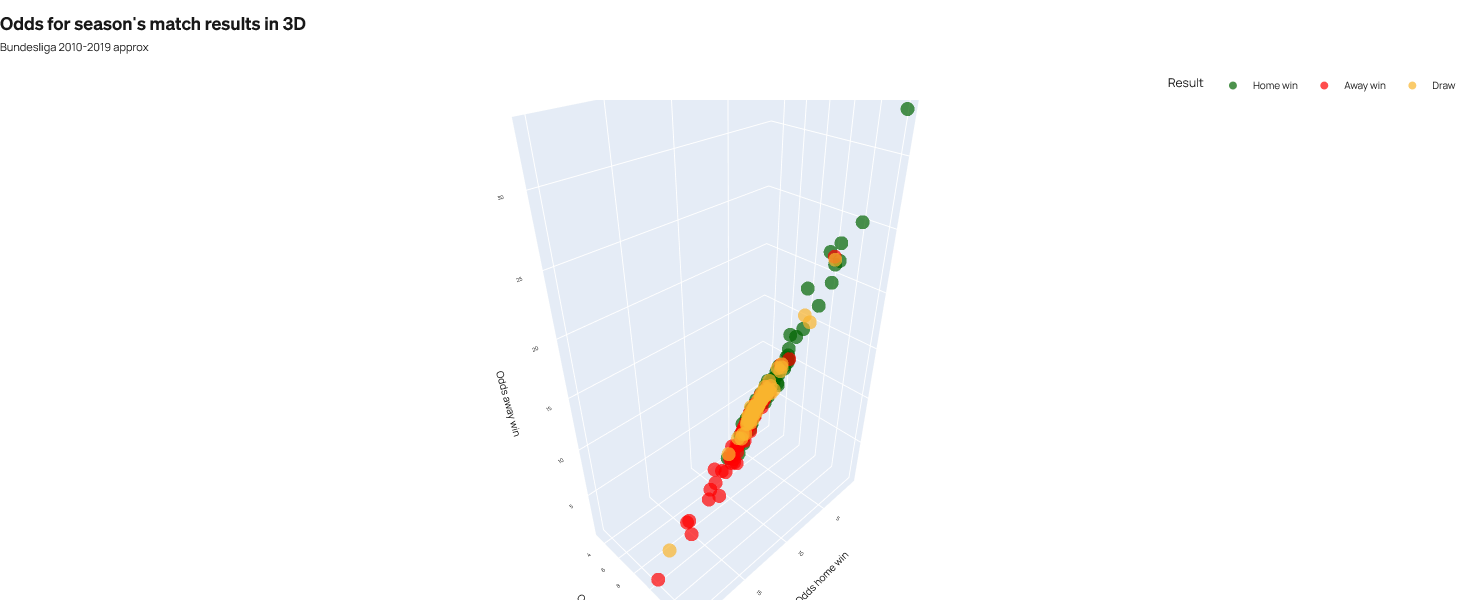

In [165]:
def make3DSCATTER(df):
    
    fig = px.scatter_3d(df, x='Odds home win', y='Odds draw', z='Odds away win', 
                        color='Result',
                        color_discrete_map={"Home win": f'rgb({colors["Home win"]["r"]},{colors["Home win"]["g"]},{colors["Home win"]["b"]})', \
                                            "Draw": f'rgb({colors["Draw"]["r"]},{colors["Draw"]["g"]},{colors["Draw"]["b"]})', \
                                            "Away win": f'rgb({colors["Away win"]["r"]},{colors["Away win"]["g"]},{colors["Away win"]["b"]})'
                                           },
                        opacity=0.7,
                        hover_name=df['Description'], 
                        hover_data={'Result': False, 'Winning odds': False, 'Date': False, 'Matchday': False, 'Odds home win': False, 'Odds draw':False, 'Odds away win': False, })

    fig.update_layout(
        title_text='Distribution of odds (W/D/L), German Bundesliga 2019/20',
        height=1000,
        width=950, 
    )

    fig.update_layout(
        hoverlabel=dict(
            bgcolor="white",
            font_size=14,
            font_family="Arial", 
        )
    )

    headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend = f'Odds for season\'s match results in 3D', 'Bundesliga 2010-2019 approx', 'cutoff for bets placed (€)', 'R.O.I (%)', None, None, True
    customChartDefaultStyling.styling(fig, headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend)

    fig.update_layout(height=600, width=None)

    fig.show()
    
make3DSCATTER(df)

### #2: As line charts
The 3D plot made me curious to see if all bets on a particular win type (eg away wins) would return a profit.

In [271]:
def eachROI(df, cutoffLO, cutoffHI, winner_type):    
    
    dfROI = pd.DataFrame(columns=['cutoffLO','cutoffHI','invest','awaywins','awaywins_pc','payout', 'profit','roi', 'hover_text'])
    invest, awaywins, awaywins_pc, payout, profit,roi = None, None, None, None, None, None
    
    dfx = df.copy()
    dfx = dfx.loc[(dfx[f'Odds {winner_type.lower()}'] > cutoffLO) & (dfx[f'Odds {winner_type.lower()}'] < cutoffHI)]
        
    invest = dfx.shape[0]
    awaywins = dfx.loc[dfx['Result'] == winner_type].shape[0]
        
    if invest > 0:
        awaywins_pc = round(awaywins/invest * 100,2)
        payout = dfx.loc[dfx['Result'] == winner_type, f'Odds {winner_type.lower()}'].sum()
        profit = payout - invest
        roi = round(profit/invest*100,2)    
        hover_text = f'€{cutoffLO} - €{cutoffHI}: {roi}% ROI'
        
        dfROI.loc[0] = cutoffLO, cutoffHI, invest, awaywins, awaywins_pc, payout, profit,roi, hover_text
        
    return dfROI

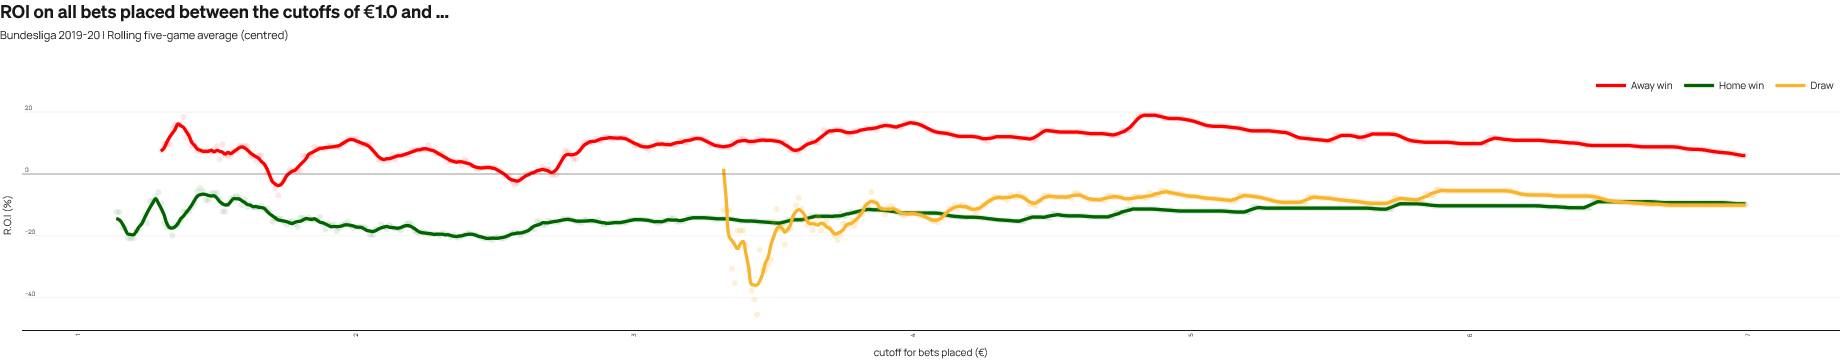

In [273]:
def plotTHREEWAY_ROI_LINE(df, LO,HI):
    
    def getCONCATDF(winner_type):

        dfCONCAT = pd.DataFrame()
        for n in range(LO,HI):    
            dfCONCAT = pd.concat([dfCONCAT, eachROI(df, LO/100, n/100, winner_type)])

        dfCONCAT['rolling_5'] = dfCONCAT['roi'].rolling(5, min_periods=1, center=True).mean()  
        dfCONCAT = dfCONCAT.reset_index(drop=True)
        
        dfCONCAT = dfCONCAT.loc[dfCONCAT.invest >= 10] ## !!
        
        return dfCONCAT
                
    ########

    fig = go.Figure()
    
    def plotEach(dfCONCAT, winner_type, line_color):
                        
        a = 0.2 if winner_type == 'Draw' else 0.1
        
        fig.add_trace(go.Scatter(
                x=dfCONCAT['cutoffHI'], 
                y=dfCONCAT['roi'],  showlegend=False,
                mode='markers', marker=dict(color=f'rgba({colors[winner_type]["r"]},{colors[winner_type]["g"]},{colors[winner_type]["b"]},{a})', size=6, symbol='circle'),
                text = dfCONCAT['hover_text'], hovertemplate='%{text}</span><extra></extra>', 
            ))

        fig.add_trace(go.Scatter(
                x=dfCONCAT['cutoffHI'], 
                y=dfCONCAT['rolling_5'],  name = winner_type,
                mode='lines', marker=dict(), line=dict(width=3.33, color=f'rgb({colors[winner_type]["r"]},{colors[winner_type]["g"]},{colors[winner_type]["b"]})'), line_shape='spline',
                hoverinfo='skip',
            ))
        
    for winner_type in ['Away win', 'Home win', 'Draw']:
        line_colors = {'Away win': 'rgba(250,100,100,1)', 'Home win':'rgba(155,190,0,1)', 'Draw': 'rgba(255,190,0,1)'}
        plotEach(getCONCATDF(winner_type), winner_type, line_colors[winner_type])

    fig.add_hline(y=0, line=dict(width=1, color='rgba(55,55,55,0.5)'))
    
    headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend = f'ROI on all bets placed between the cutoffs of €{LO/100} and ... ', 'Bundesliga 2019-20 | Rolling five-game average (centred)', 'cutoff for bets placed (€)', 'R.O.I (%)', None, None, True
    customChartDefaultStyling.styling(fig, headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend)

    fig.show()
    
plotTHREEWAY_ROI_LINE(df, 100, 700)

### #3: Scatter Heatmap 
I then wanted to refine this further, for away wins, to see if there was an ideal zone (eg 3.10 - 5.43) for making returns, though I would caution that this data looks at just one year and an exact zone will be unlikely to translate across seasons. 

In [6]:
dfHMROI = pd.DataFrame()
dfHMINV = pd.DataFrame()

def getData(winner_type, LO, HI, skipper):
    
    for nLO in range(LO,HI, skipper):
                
        for nHI in range(LO,HI, skipper):
            
            if nHI > nLO:
    
                dfx = eachROI(nLO/100, nHI/100, winner_type)
                roi = dfx['roi'].values

                roi = None if len(roi) == 0 else roi[0]
                                
                invest = dfx['invest'].values
                invest = None if len(invest) == 0 else invest[0]

                dfHMROI.loc[nLO/100, nHI/100] = roi
                dfHMINV.loc[nLO/100, nHI/100] = invest
                
        
    return dfHMROI, dfHMINV.fillna(0)

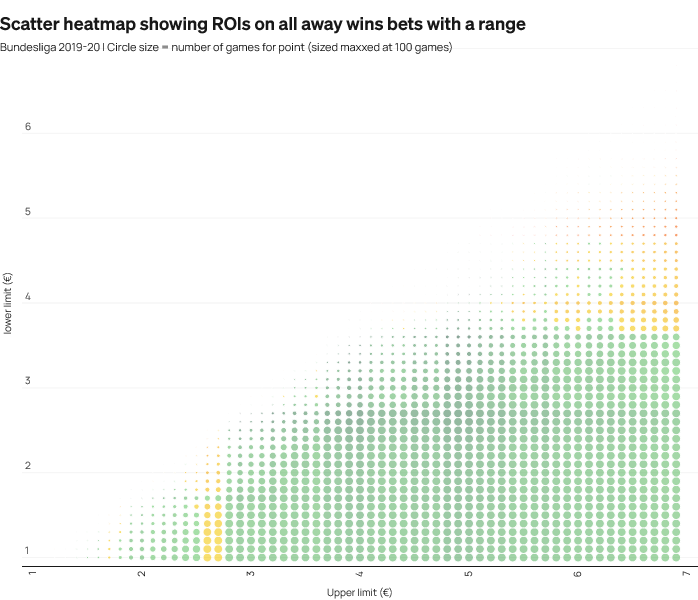

In [166]:
def makeHEATMAPSCATTER(winner_type, LO, HI, skipper):

    dfHMROI, dfHMINV = getData(winner_type, LO, HI, skipper)

    ### 
    
    fig = go.Figure()
        
    for index, row in dfHMROI.iterrows():
                
        cs = [x for x in row.values]
        cs = [0.0 if pd.isnull(x) else x for x in cs] 
        cs = [f'rgba(244, {200 - (x/100) * - 200}, 0, 0.8)'  if x < 0 else f'rgba({50 - ((x/dfHMROI.fillna(0).values.max()) * 50)}, {100 - ((x/dfHMROI.fillna(0).values.max()) * 100)}, 0, 0.8)' \
              
              if x > 100 else f'rgba({100 - ((x/100) * 100)}, {200 - ((x/100) * 200)}, {100 - (((x**2)/10000) * 100)}, 0.8)' for x in cs]     
    
        ss = [10 if x > 100 else x/10 for x in dfHMINV.loc[index]]
        ts = [x for x in dfHMROI.loc[index]]
                        
        fig.add_trace(go.Scatter(
                x=[x for x in dfHMROI.columns], y=[index for x in dfHMROI.columns],  
                showlegend=False,
                mode='markers', marker=dict(color=cs, size=ss, symbol='circle'),
                text=ts, hovertemplate='%{text}%</span><extra></extra>'
            ))
    
    headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend = f'Scatter heatmap showing ROIs on all {winner_type.lower()}s bets with a range', 'Bundesliga 2019-20 | Circle size = number of games for point (sized maxxed at 100 games)', None, None, 600, 40, True
    customChartDefaultStyling.styling(fig, headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend)

    fig.update_xaxes(tickfont=dict(size=10), title=f'Upper limit (€)', range=[0.9,7.1])
    fig.update_yaxes(tickfont=dict(size=10), title=f'lower limit (€)', range=[0.9,7.1])
    
    fig.show()
        
makeHEATMAPSCATTER('Away win', 200, 400, 10)

### #4: Line Scatter

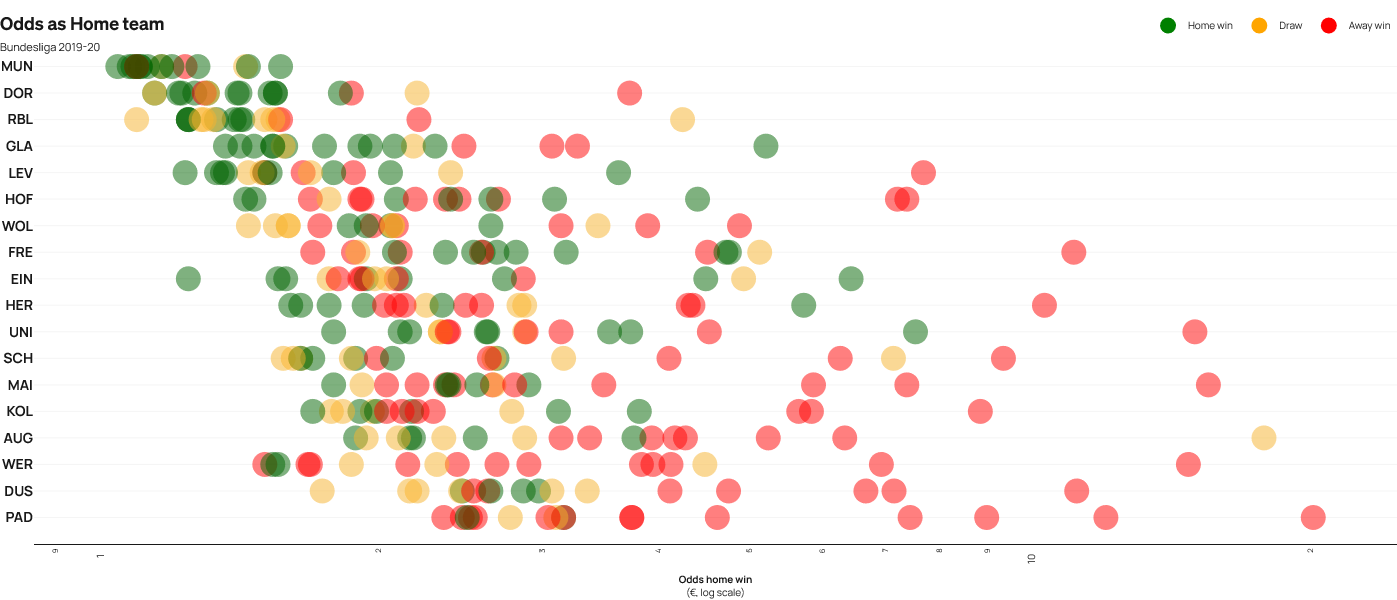

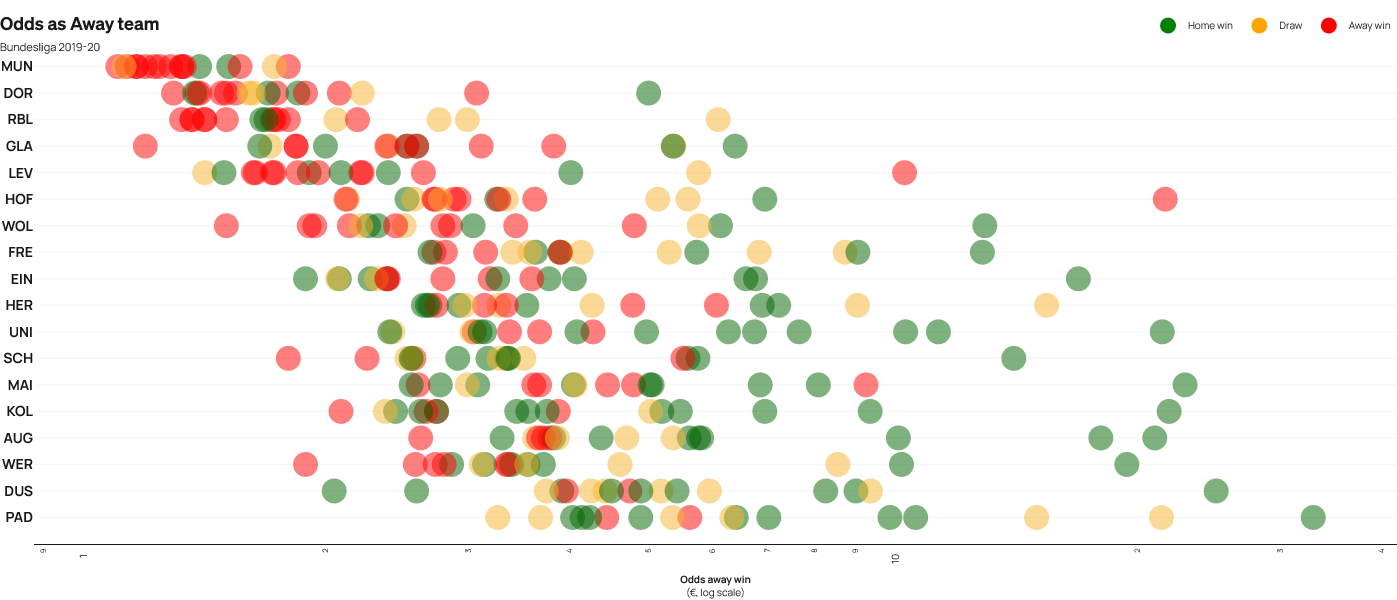

In [18]:
def teamsOdds(ha):
    
    odds_col = f'Odds {ha.lower().replace("team","win")}'
    
    table_order = {'MUN': 1, 'DOR': 2, 'RBL': 3, 'GLA': 4, 'LEV': 5, 'HOF': 6, 'WOL': 7, 'FRE': 8, 'EIN': 9, 'HER': 10, 'UNI': 11, 'SCH': 12, 'MAI': 13, 'KOL': 14, 'AUG': 15, 'WER': 16, 'DUS': 17, 'PAD': 18}
    teams_order = {value:key for key, value in table_order.items()} 

    yticks = []
    for n in range(18,0,-1):
        yticks.append(f'<b>{teams_order[n]}</b>')
    
    ##########

    fig = go.Figure()
        
    for team in table_order.keys():
        
        n = 19 - table_order[team]
                
        dfx = df.loc[df[ha]==team]
                
        teams_odds = dfx[odds_col]
        
        cs = [f'rgba({colors["Home win"]["r"]},{colors["Home win"]["g"]},{colors["Home win"]["b"]}, 0.5)' if x == 'Home win' else f'rgba({colors["Draw"]["r"]},{colors["Draw"]["g"]},{colors["Draw"]["b"]}, 0.5)' if x == 'Draw' else f'rgba({colors["Away win"]["r"]},{colors["Away win"]["g"]},{colors["Away win"]["b"]}, 0.5)' if x == 'Away win' else 'black' for x in dfx['Result']]
            
        ts = [x for x in dfx['Description']]
            
        fig.add_trace(go.Scatter(
                x=[x for x in teams_odds], y=[n for x in teams_odds],  
                showlegend=False,
                mode='markers', marker=dict(color=cs, size=25, symbol='circle'), 
                text=ts, hovertemplate='%{text}</span><extra></extra>'
            ))
        
    fig.add_trace(go.Scatter(x=[0], y=[0], name = 'Home win', showlegend=True, mode='markers', marker=dict(color='green', size=25,), hoverinfo='skip'))
    fig.add_trace(go.Scatter(x=[0], y=[0], name = 'Draw', showlegend=True, mode='markers', marker=dict(color='orange', size=25,), hoverinfo='skip'))
    fig.add_trace(go.Scatter(x=[0], y=[0], name = 'Away win', showlegend=True, mode='markers', marker=dict(color='red', size=25,), hoverinfo='skip'))
      
    headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend = f'Odds as {ha}', 'Bundesliga 2019-20 ', None, None, 600, 40, True
    customChartDefaultStyling.styling(fig, headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend)
    
    fig.update_layout(
        yaxis = dict(
            tickmode = 'array',
            tickvals = [x for x in range(1,len(teams_order)+1)],
            ticktext = yticks
        )
    )
    
    fig.update_xaxes(tickfont=dict(size=10), title=f'<b>{odds_col}</b><br>(€, log scale)', type="log")
    fig.update_yaxes(tickfont=dict(size=14), ticklabelposition="outside", range=[0,19])
    
    fig.show()
        
teamsOdds('Home team')
teamsOdds('Away team')

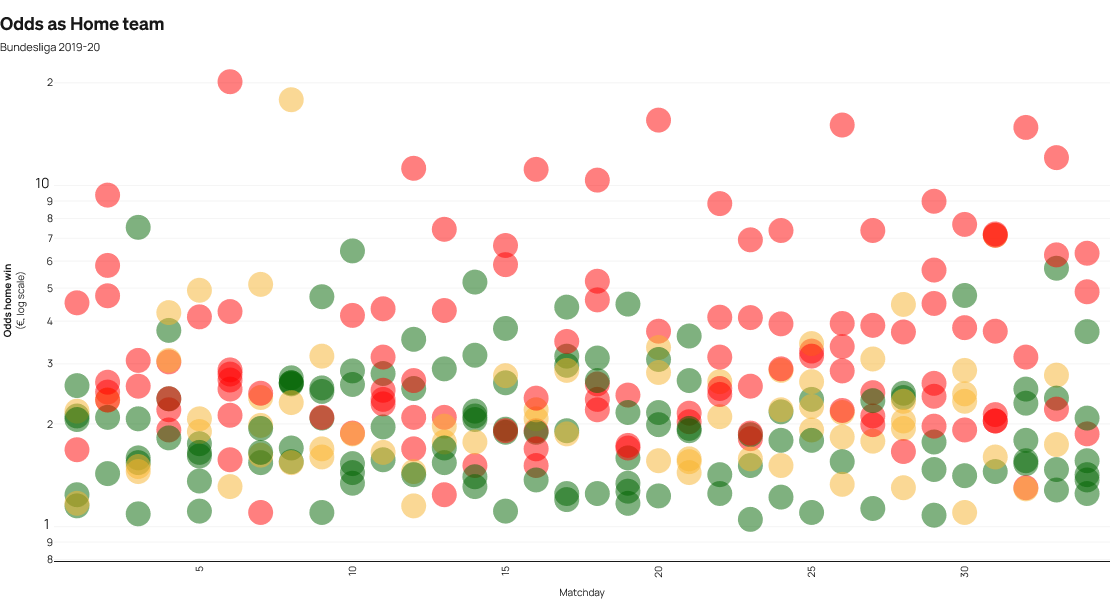

In [258]:
def matchdayOdds(ha):
        
    fig = go.Figure()
    
    odds_col = f'Odds {ha.lower().replace("team","win")}'
    
    matchdays = sorted([int(x) for x in df['Matchday'].unique()])
        
    for matchday in matchdays:
                        
        dfx = df.loc[df['Matchday'] == str(matchday)]
        
        teams_odds = dfx[odds_col]
        
        cs = [f'rgba({colors["Home win"]["r"]},{colors["Home win"]["g"]},{colors["Home win"]["b"]}, 0.5)' if x == 'Home win' else f'rgba({colors["Draw"]["r"]},{colors["Draw"]["g"]},{colors["Draw"]["b"]}, 0.5)' if x == 'Draw' else f'rgba({colors["Away win"]["r"]},{colors["Away win"]["g"]},{colors["Away win"]["b"]}, 0.5)' if x == 'Away win' else 'black' for x in dfx['Result']]
            
        ts = [x for x in dfx['Description']]
        
        fig.add_trace(go.Scatter(
                x=[matchday for x in teams_odds], y=[x for x in teams_odds],  
                showlegend=False,
                mode='markers', marker=dict(color=cs, size=25, symbol='circle'), 
                text=ts, hovertemplate='%{text}</span><extra></extra>'
            ))
        
    headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend = f'Odds as {ha}', 'Bundesliga 2019-20 ', None, None, 600, 40, True
    customChartDefaultStyling.styling(fig, headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend)
     
    fig.update_xaxes(tickfont=dict(size=10), title='Matchday', range=[0.25,34.75])
    fig.update_yaxes(tickfont=dict(size=14), ticklabelposition="outside", title=f'<b>{odds_col}</b><br>(€, log scale)', type="log")
    
    fig.show()
        
matchdayOdds('Home team')

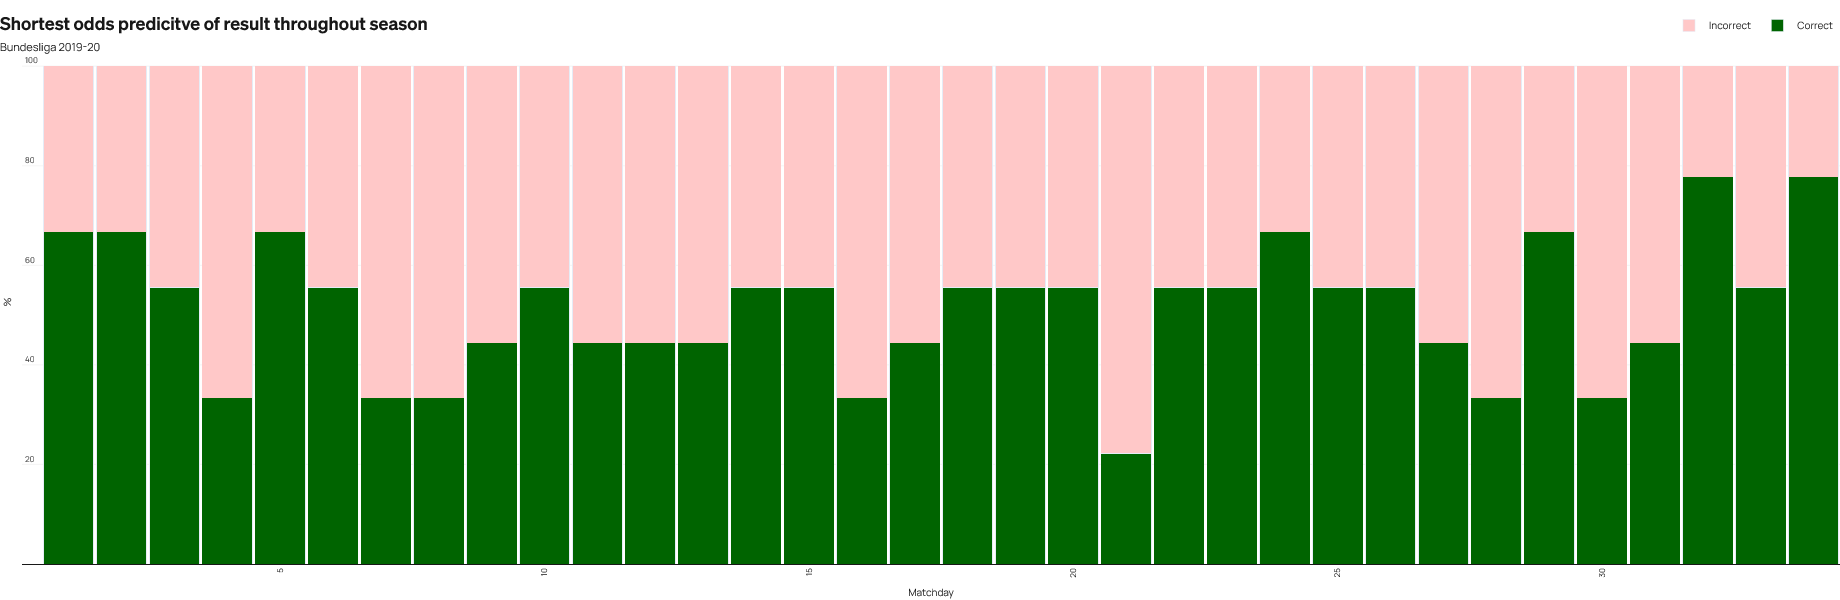

In [262]:
def matchdayCorrect():
        
    dfCORRECT = pd.DataFrame(columns=['number_of_matches', 'number_of_correct', 'correct_pc', 'incorrect_pc'])

    fig = go.Figure()
        
    matchdays = sorted([int(x) for x in df['Matchday'].unique()])
        
    for matchday in matchdays:
                        
        dfx = df.copy().loc[df['Matchday'] == str(matchday)]
        dfx['Winning odds'] = dfx['Winning odds'].apply(lambda x: x.replace('$',''))
        dfx['Winning odds'] = dfx['Winning odds'].astype(float)
        
        number_of_matches = dfx.shape[0]
        
        dfxx = dfx.loc[dfx['Winning odds'] == dfx['Shortest odds']]
        number_of_correct = dfxx.shape[0]
        
        correct_pc = round(number_of_correct/number_of_matches*100,2)
        incorrect_pc = 100 - correct_pc
        
        dfCORRECT.loc[int(matchday)] = number_of_matches, number_of_correct, correct_pc, incorrect_pc
                  
    fig.add_trace(go.Bar(
            x=[x for x in dfCORRECT.index], y=dfCORRECT['correct_pc'], marker=dict(color='rgba(0,100,0,1)'), name = 'Correct', hoverinfo='skip'
        ))
    
    fig.add_trace(go.Bar(
            x=[x for x in dfCORRECT.index], y=dfCORRECT['incorrect_pc'],  marker=dict(color='rgba(255,200,200,1)'), name = 'Incorrect', hoverinfo='skip'
        ))
    
    fig.update_layout(barmode='stack')
        
    headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend = f'Shortest odds predicitve of result throughout season', 'Bundesliga 2019-20 ', None, None, 600, 40, True
    customChartDefaultStyling.styling(fig, headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend)
     
    fig.update_xaxes(tickfont=dict(size=8), title='Matchday')
    fig.update_yaxes(tickfont=dict(size=8), title=f'%')
    
    fig.update_layout(bargap=0.05)    
    fig.show()
                
matchdayCorrect()

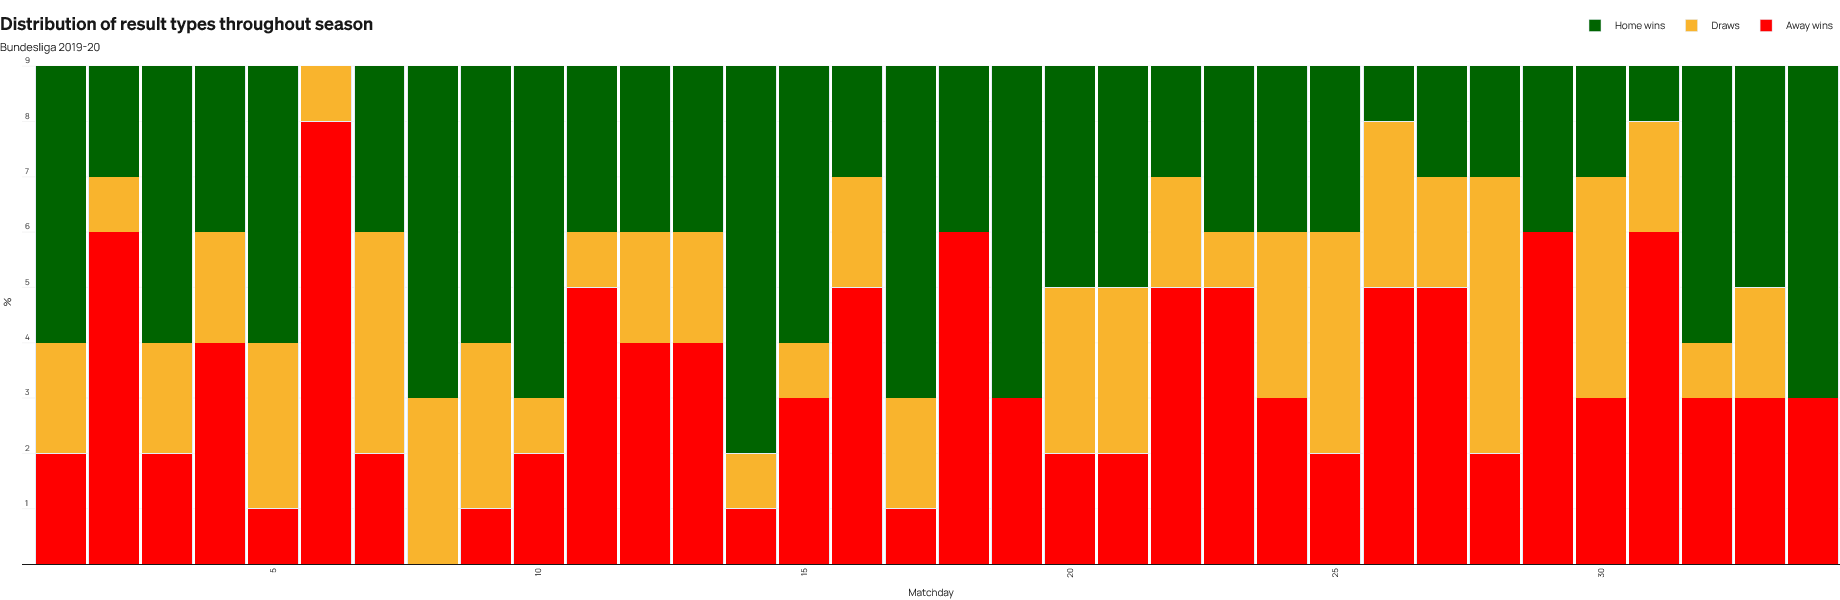

In [263]:
def matchdayHDAdistro():
        
    dfCORRECT = pd.DataFrame(columns=['number_of_matches', 'number_of_home_wins', 'number_of_draws', 'number_of_away_wins'])

    fig = go.Figure()
        
    matchdays = sorted([int(x) for x in df['Matchday'].unique()])
        
    for matchday in matchdays:
                        
        dfx = df.copy().loc[df['Matchday'] == str(matchday)]
        dfx['Winning odds'] = dfx['Winning odds'].apply(lambda x: x.replace('$',''))
        dfx['Winning odds'] = dfx['Winning odds'].astype(float)
        
        number_of_matches = dfx.shape[0]
        number_of_home_wins = dfx.loc[dfx['Result']=='Home win'].shape[0]
        number_of_draws = dfx.loc[dfx['Result']=='Draw'].shape[0]
        number_of_away_wins = dfx.loc[dfx['Result']=='Away win'].shape[0]

        dfCORRECT.loc[int(matchday)] = number_of_matches, number_of_home_wins, number_of_draws, number_of_away_wins
                  
            
    fig.add_trace(go.Bar(
            x=[x for x in dfCORRECT.index], y=dfCORRECT['number_of_away_wins'], marker=dict(color=f'rgba({colors["Away win"]["r"]},{colors["Away win"]["g"]},{colors["Away win"]["b"]},1)'), name = 'Away wins', hoverinfo='skip'
        ))
    
    fig.add_trace(go.Bar(
            x=[x for x in dfCORRECT.index], y=dfCORRECT['number_of_draws'], marker=dict(color=f'rgba({colors["Draw"]["r"]},{colors["Draw"]["g"]},{colors["Draw"]["b"]},1)'), name = 'Draws', hoverinfo='skip'
        ))
        
    fig.add_trace(go.Bar(
            x=[x for x in dfCORRECT.index], y=dfCORRECT['number_of_home_wins'], marker=dict(color=f'rgba({colors["Home win"]["r"]},{colors["Home win"]["g"]},{colors["Home win"]["b"]},1)'), name = 'Home wins', hoverinfo='skip'
        ))
    
    fig.update_layout(barmode='stack')
        
    headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend = f'Distribution of result types throughout season', 'Bundesliga 2019-20 ', None, None, 600, 40, True
    customChartDefaultStyling.styling(fig, headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend)
     
    fig.update_xaxes(tickfont=dict(size=8), title='Matchday')
    fig.update_yaxes(tickfont=dict(size=8), title=f'%')
    
    fig.update_layout(bargap=0.05)    
    fig.show()
                
matchdayHDAdistro()

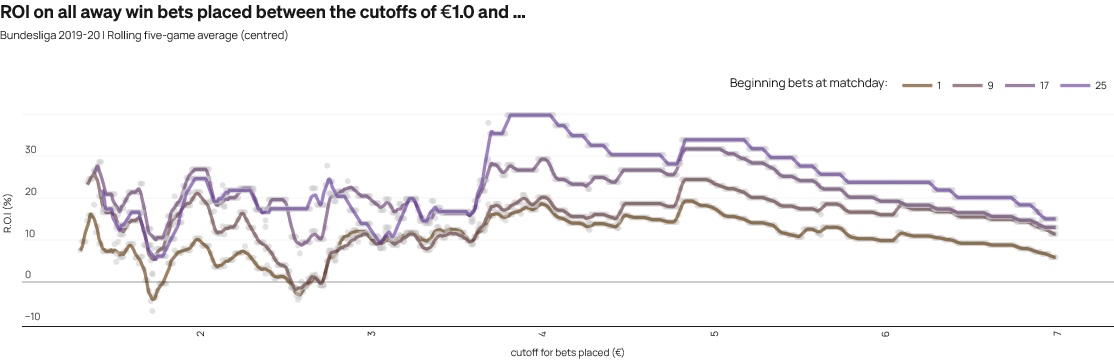

In [313]:
def plotROI_LINE_AWAYONLY_TIME(df, LO,HI):
    
    def getCONCATDF(dfMD, winner_type):

        dfCONCAT = pd.DataFrame()
        for n in range(LO,HI):    
            dfCONCAT = pd.concat([dfCONCAT, eachROI(dfMD, LO/100, n/100, winner_type)])

        dfCONCAT['rolling_5'] = dfCONCAT['roi'].rolling(5, min_periods=1, center=True).mean()  
        dfCONCAT = dfCONCAT.reset_index(drop=True)
        
        dfCONCAT = dfCONCAT.loc[dfCONCAT.invest >= 10] ## !!
        
        return dfCONCAT
                
    ########

    fig = go.Figure()
    
    def plotEach(dfCONCAT, winner_type, line_color, matchday):
                        
        a = 0.2 if winner_type == 'Draw' else 0.1
        
        fig.add_trace(go.Scatter(
                x=dfCONCAT['cutoffHI'], 
                y=dfCONCAT['roi'],  showlegend=False, 
                mode='markers', marker=dict(color='rgba(200,200,200,0.5)', size=6, symbol='circle'),
                hoverinfo='skip', 
            
            ))

        fig.add_trace(go.Scatter(
                x=dfCONCAT['cutoffHI'], 
                y=dfCONCAT['rolling_5'],  name = matchday,
                mode='lines', marker=dict(), line=dict(width=3.33, color=line_color), line_shape='spline',
                hoverinfo='skip',
            ))
        
    matchdays = sorted([int(x) for x in df['Matchday'].unique()])
        
    matchdays_to_plot =  matchdays[::8]
    for matchday in matchdays_to_plot:
                
        dfMD = df.copy()
        dfMD['Matchday'] = dfMD['Matchday'].astype(int)
        dfMD = dfMD.loc[dfMD['Matchday'] > matchday]
        
        for winner_type in ['Away win',]:
                
            line_colors = {'Away win': f'rgba(92, 50, {matchdays_to_plot.index(matchday) * (255/len(matchdays_to_plot))}, 0.6)'}
                        
            plotEach(getCONCATDF(dfMD, winner_type), winner_type, line_colors[winner_type], matchday)

    fig.add_hline(y=0, line=dict(width=1, color='rgba(55,55,55,0.5)'))
    
    headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend = f'ROI on all away win bets placed between the cutoffs of €{LO/100} and ... ', 'Bundesliga 2019-20 | Rolling five-game average (centred)', 'cutoff for bets placed (€)', 'R.O.I (%)', None, None, True
    customChartDefaultStyling.styling(fig, headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend)

    fig.update_layout(legend_title_text='Beginning bets at matchday:')
    
    fig.update_xaxes(tickfont=dict(size=10))
    fig.update_yaxes(tickfont=dict(size=10))
    
    fig.show()
    
plotROI_LINE_AWAYONLY_TIME(df, 100, 700)